# Loading Libraries

In [22]:
import librosa
import os
from google.colab import drive
from google.colab import files
import math
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statistics import mode
import seaborn as sns
from sklearn.metrics import confusion_matrix
# import librosa.display
# import tensorflow.keras as keras
# from keras.callbacks import ModelCheckpoint
# import IPython.display as ipd

In [23]:
drive.mount('/content/drive') #mounting drive so that we can access the dataset that has been uploaded

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Curating Dataset

## Initializing Paths

In [24]:
# Training Dataset Path
training_dataset_path = "/content/drive/MyDrive/AI_voice_data/TrainingData"
training_json_path = "/content/train_data.json" #path of json when json created first time

##Setting Hyper-Parametes

In [25]:
# Hyper-parameters for Audio Images
SAMPLE_RATE = 22050
TRACK_SAMPLE = 10
NUM_CLASSES = 10
num_mfcc = 32
n_fft = 2048
hop_length = 512

# Hyper-paremeters for MLP
EPOCHS = 50
TRAIN_TEST_SPLIT = 0.2
LEARNING_RATE = 0.0001
BATCH_SIZE = 10
SHUFFLE_DATA = True

## Creating MFCC Dataset

In [5]:
def save_mfcc(dataset_path, json_path):
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
    for root, dirs, files in os.walk(dataset_path):
      for _, name in tqdm(enumerate(files)):
            file_path = os.path.join(root, name)
            
            person = name.split(".")[0].split("_")[0]
            if person in data["mapping"]:
              pass
            else:
              data["mapping"].append(person)

            signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
            duration = librosa.get_duration(y=signal, sr=sample_rate) #duration in seconds
            d = 0
            print(data["mapping"][-1])

            for i in range(0, math.floor(duration), TRACK_SAMPLE): #generating mfccs for random segments in songs

                if (i+10) > duration:
                  continue
                
                start = i * SAMPLE_RATE
                finish = (i + TRACK_SAMPLE) * SAMPLE_RATE


                mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T

                data["mfcc"].append(mfcc.tolist()) #converting to lst as numpy arr not stored by json file
                data["labels"].append(data["mapping"].index(person)) #stores the genre label index

                # print("{}, segment:{}".format(file_path, d+1))
                d += 1

    #creating a json file to save all mfccs and relevant details of each song segment
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [6]:
save_mfcc(training_dataset_path, training_json_path)

0it [00:00, ?it/s]

Shayan Aamir


1it [00:07,  7.81s/it]

Shayan Aamir


2it [00:14,  6.97s/it]

Usman Qadir


3it [00:22,  7.48s/it]

Usman Qadir


4it [00:27,  6.68s/it]

Khubaib Sattar


5it [00:37,  7.80s/it]

Khubaib Sattar


6it [00:43,  7.18s/it]

Muhammad Zain


7it [00:51,  7.43s/it]

Muhammad Zain


8it [00:57,  6.85s/it]

Shafaq Mughal


9it [01:06,  7.80s/it]

Shafaq Mughal


10it [01:13,  7.40s/it]

Akeel Athar


11it [01:21,  7.75s/it]

Akeel Athar


12it [01:27,  7.00s/it]

Omar Zia


13it [01:35,  7.38s/it]

Omar Zia


14it [01:41,  7.01s/it]

Fizza Rubab


15it [01:49,  7.24s/it]

Fizza Rubab


16it [01:54,  6.53s/it]

Umema Zehra


17it [02:03,  7.18s/it]

Ayesha Syed


18it [02:11,  7.30s/it]


# Creating our MLP model

## Layer Class

In [26]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

## Relu Activation

In [27]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

## Sigmoid Activation

In [28]:
class Sigmoid(Layer):
    def __init__(self):
        """Sigmoid layer simply applies sigmoid activation function to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise sigmoid to [batch, input_units] matrix"""
        sigmoid_forward = 1/(1+np.exp(-input))
        return sigmoid_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Sigmoid input"""
        sigmoid_forward = 1/(1+np.exp(-input))
        sigmoid_grad = sigmoid_forward*(1-sigmoid_forward)
        return grad_output*sigmoid_grad 

## Dense Layer

In [29]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.01):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <X,W> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, scale = np.sqrt(2/(input_units+output_units)), size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <X,W> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)/input.shape[0]


        grad_biases = grad_output.sum(axis=0)/input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

## Loss Functions

In [30]:
def softmax(z):
  exp = np.exp(z-np.max(z,axis=1,keepdims=True))
  probs = exp/np.sum(exp,axis=1,keepdims=True)
  return probs

def one_hot(y,c):
   y_hot = np.zeros((len(y),c ))
   y_hot[np.arange(len(y)), y] = 1
   return y_hot

def cross_entropy_loss(logits,y):
   y_hat = softmax(logits)
   y_hot = one_hot(y,NUM_CLASSES)
   loss = -np.sum(np.log(y_hat)*y_hot)/y.shape[0]
   return loss

def grad_cross_entropy_loss(logits,y):
    y_hat = softmax(logits)
    y_hot = one_hot(y,NUM_CLASSES)
    return (y_hat - y_hot)

## Main MLP Class

In [31]:
class MLP:
  def __init__(self,n) -> None:
      self.network = n
  def forward(self, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in self.network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(self.network)
    return activations
  def predict(self,X):
      """
      Compute network predictions. Returning indices of largest Logit probability
      """
      logits = self.forward(X)[-1]
      return np.argmax(softmax(logits),axis=1)
  def train(self,X,y):
      """
      Train our network on a given batch of X and y.
      We first need to run forward to get all layer activations.
      Then we can run layer.backward going from last to first layer.
      After we have called backward for all layers, all Dense layers have already made one gradient step.
      """
      
      # Get the layer activations
      layer_activations = self.forward(X)
      layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
      logits = layer_activations[-1]
      
      # Compute the loss and the initial gradient
  
      loss = cross_entropy_loss(logits,y)

      loss_grad = grad_cross_entropy_loss(logits,y)
      
      # Propagate gradients through the network
      # Reverse propogation as this is backprop
      for layer_index in range(len(self.network))[::-1]:
          layer = self.network[layer_index]
          
          loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
          
      return np.mean(loss)



# Loading Dataset

In [32]:
def load_data(data_path): #open and read json from given path
    with open(data_path, "r") as fp:
        data = json.load(fp)

    #save mfcc in X and relevant data in y and z
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z

def prepare_datasets(dataset_path, test_size):
    # load data
    X, y, z = load_data(dataset_path)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_test, y_train,  y_test, z

## Generating Train/Test Splits

In [33]:
X_train, X_test, y_train,  y_test, z = prepare_datasets(training_json_path, TRAIN_TEST_SPLIT)

input_shape = (X_train.shape[1], X_train.shape[2], 1) 

X_train.shape

(400, 431, 32, 1)

In [34]:
X_train_flatten = X_train.reshape((X_train.shape[0], -1))
X_test_flatten = X_test.reshape((X_test.shape[0], -1))

# Initializing Model

In [35]:
network = []
train_log = []
val_log = []

network.append(Dense(X_train_flatten.shape[1], 1024, learning_rate = LEARNING_RATE))
network.append(ReLU())
network.append(Dense(1024, NUM_CLASSES, learning_rate = LEARNING_RATE))

In [36]:
model = MLP(n = network)

# Training Model

In [37]:
# Minibatch Stochastic Gradient Descent
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
  2%|▏         | 1/50 [00:04<03:32,  4.35s/it]

Epoch 0
Train accuracy: 0.255


  4%|▍         | 2/50 [00:08<03:27,  4.33s/it]

Epoch 1
Train accuracy: 0.3225


  6%|▌         | 3/50 [00:13<03:24,  4.36s/it]

Epoch 2
Train accuracy: 0.3875


  8%|▊         | 4/50 [00:17<03:19,  4.33s/it]

Epoch 3
Train accuracy: 0.43


 10%|█         | 5/50 [00:21<03:15,  4.34s/it]

Epoch 4
Train accuracy: 0.4625


 12%|█▏        | 6/50 [00:25<03:09,  4.31s/it]

Epoch 5
Train accuracy: 0.5275


 14%|█▍        | 7/50 [00:30<03:06,  4.34s/it]

Epoch 6
Train accuracy: 0.5275


 16%|█▌        | 8/50 [00:34<03:01,  4.33s/it]

Epoch 7
Train accuracy: 0.5575


 18%|█▊        | 9/50 [00:40<03:13,  4.73s/it]

Epoch 8
Train accuracy: 0.65


 20%|██        | 10/50 [00:44<03:04,  4.61s/it]

Epoch 9
Train accuracy: 0.7


 22%|██▏       | 11/50 [00:48<02:56,  4.52s/it]

Epoch 10
Train accuracy: 0.6225


 24%|██▍       | 12/50 [00:53<02:49,  4.46s/it]

Epoch 11
Train accuracy: 0.665


 26%|██▌       | 13/50 [00:57<02:43,  4.42s/it]

Epoch 12
Train accuracy: 0.7725


 28%|██▊       | 14/50 [01:01<02:39,  4.42s/it]

Epoch 13
Train accuracy: 0.8175


 30%|███       | 15/50 [01:08<02:56,  5.04s/it]

Epoch 14
Train accuracy: 0.87


 32%|███▏      | 16/50 [01:13<02:48,  4.95s/it]

Epoch 15
Train accuracy: 0.8475


 34%|███▍      | 17/50 [01:17<02:40,  4.86s/it]

Epoch 16
Train accuracy: 0.81


 36%|███▌      | 18/50 [01:22<02:33,  4.81s/it]

Epoch 17
Train accuracy: 0.9375


 38%|███▊      | 19/50 [01:27<02:27,  4.74s/it]

Epoch 18
Train accuracy: 0.905


 40%|████      | 20/50 [01:32<02:24,  4.82s/it]

Epoch 19
Train accuracy: 0.975


 42%|████▏     | 21/50 [01:37<02:27,  5.09s/it]

Epoch 20
Train accuracy: 0.73


 44%|████▍     | 22/50 [01:42<02:18,  4.95s/it]

Epoch 21
Train accuracy: 0.985


 46%|████▌     | 23/50 [01:47<02:10,  4.85s/it]

Epoch 22
Train accuracy: 0.9975


 48%|████▊     | 24/50 [01:51<02:04,  4.78s/it]

Epoch 23
Train accuracy: 0.9925


 50%|█████     | 25/50 [01:56<01:58,  4.73s/it]

Epoch 24
Train accuracy: 0.9925


 52%|█████▏    | 26/50 [02:00<01:52,  4.70s/it]

Epoch 25
Train accuracy: 0.9975


 54%|█████▍    | 27/50 [02:05<01:47,  4.68s/it]

Epoch 26
Train accuracy: 1.0


 56%|█████▌    | 28/50 [02:10<01:42,  4.65s/it]

Epoch 27
Train accuracy: 1.0


 58%|█████▊    | 29/50 [02:14<01:37,  4.64s/it]

Epoch 28
Train accuracy: 1.0


 60%|██████    | 30/50 [02:19<01:32,  4.62s/it]

Epoch 29
Train accuracy: 1.0


 62%|██████▏   | 31/50 [02:23<01:27,  4.61s/it]

Epoch 30
Train accuracy: 1.0


 64%|██████▍   | 32/50 [02:28<01:24,  4.72s/it]

Epoch 31
Train accuracy: 1.0


 66%|██████▌   | 33/50 [02:34<01:24,  4.97s/it]

Epoch 32
Train accuracy: 1.0


 68%|██████▊   | 34/50 [02:39<01:20,  5.05s/it]

Epoch 33
Train accuracy: 1.0


 70%|███████   | 35/50 [02:45<01:16,  5.12s/it]

Epoch 34
Train accuracy: 1.0


 72%|███████▏  | 36/50 [02:49<01:09,  4.96s/it]

Epoch 35
Train accuracy: 1.0


 74%|███████▍  | 37/50 [02:54<01:03,  4.85s/it]

Epoch 36
Train accuracy: 1.0


 76%|███████▌  | 38/50 [02:58<00:57,  4.77s/it]

Epoch 37
Train accuracy: 1.0


 78%|███████▊  | 39/50 [03:03<00:51,  4.72s/it]

Epoch 38
Train accuracy: 1.0


 80%|████████  | 40/50 [03:08<00:46,  4.69s/it]

Epoch 39
Train accuracy: 1.0


 82%|████████▏ | 41/50 [03:12<00:42,  4.69s/it]

Epoch 40
Train accuracy: 1.0


 84%|████████▍ | 42/50 [03:17<00:37,  4.67s/it]

Epoch 41
Train accuracy: 1.0


 86%|████████▌ | 43/50 [03:21<00:32,  4.66s/it]

Epoch 42
Train accuracy: 1.0


 88%|████████▊ | 44/50 [03:27<00:30,  5.03s/it]

Epoch 43
Train accuracy: 1.0


 90%|█████████ | 45/50 [03:32<00:24,  4.90s/it]

Epoch 44
Train accuracy: 1.0


 92%|█████████▏| 46/50 [03:37<00:19,  4.80s/it]

Epoch 45
Train accuracy: 1.0


 94%|█████████▍| 47/50 [03:41<00:14,  4.75s/it]

Epoch 46
Train accuracy: 1.0


 96%|█████████▌| 48/50 [03:46<00:09,  4.71s/it]

Epoch 47
Train accuracy: 1.0


 98%|█████████▊| 49/50 [03:50<00:04,  4.70s/it]

Epoch 48
Train accuracy: 1.0


100%|██████████| 50/50 [03:55<00:00,  4.71s/it]

Epoch 49
Train accuracy: 1.0


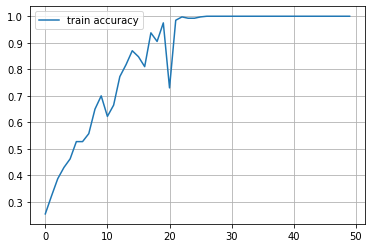

In [38]:
# Training the model
for epoch in tqdm(range(EPOCHS)):
    for x_batch,y_batch in iterate_minibatches(X_train_flatten, y_train, batchsize=BATCH_SIZE, shuffle=SHUFFLE_DATA):
        model.train(x_batch,y_batch)
    
    train_log.append(np.mean(model.predict(X_train_flatten)==y_train))

    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])

plt.plot(train_log,label='train accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [39]:
# predictions = model.predict(X_test_flatten)
# accuracy = np.mean(predictions==y_test)
# print(accuracy)

In [40]:
# testing and printing predictions on all of the test data
preds = []
targets = []
print("Predicting on all song segments from test data and saving them too...")

for i in range(len(X_test_flatten)):
  y_pred = model.predict(X_test_flatten[i].reshape((1, -1)))
  preds.append(y_pred)
  targets.append(y_test[i]) 

Predicting on all song segments from test data and saving them too...


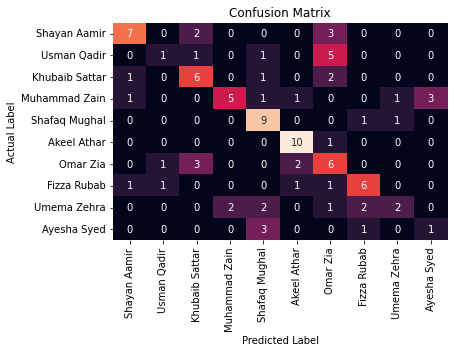

0.1073
0.0

Test Accuracy: 53.0


In [47]:
# Confusion matrix
cm = confusion_matrix(targets, preds)
# print(cm)

class_label = z #mapping in json had a list of all classes
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt= "d", cbar = False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

count = 0
for i in range(len(targets)):
  if targets[i] == preds[i]:
    count += 1
print("\nTest Accuracy:", count/len(targets) * 100)

#Validating Data on OutSide data

In [42]:
def new_song_predict(audio_path, model, z):
    name = audio_path.split("/")[-1].split("_")[0]
    signal, sample_rate = librosa.load(audio_path, sr=SAMPLE_RATE)
    duration = librosa.get_duration(y=signal, sr=sample_rate) #duration in seconds
    results = []

    d = 0
    for i in range(0, math.floor(duration), TRACK_SAMPLE): #generating mfccs for random segments in songs

        if (i+10) > duration:
          continue
    
        start = i * SAMPLE_RATE
        finish = (i + TRACK_SAMPLE) * SAMPLE_RATE

        # OR you can just do
        # data = librosa.load(file_path, sr=SAMPLE_RATE, offset = i, duration = i + TRACK_SAMPLE)

        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T
        data = np.array(mfcc.tolist())
        data = data.reshape((1, -1))
        prediction = model.predict(data)
        results.append(prediction[0])

    return z[mode(results)], name

In [43]:
new_song_predict("/content/drive/MyDrive/AI_voice_data/TestingData/Fizza Rubab_Test.wav", model, z)

('Fizza Rubab', 'Fizza Rubab')

In [45]:
# save the model to disk
import pickle
filename = 'VoiceRecognitionModel.pkl'
pickle.dump(model, open(filename, 'wb'))

In [50]:
loaded_model = pickle.load(open('VoiceRecognitionModel.pkl', 'rb'))

In [51]:
new_song_predict("/content/drive/MyDrive/AI_voice_data/TestingData/Fizza Rubab_Test.wav", loaded_model, z)

('Fizza Rubab', 'Fizza Rubab')